## 商品信息可视化与文本处理结果可视化展示

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

sns.set_theme(style="white")
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
train = pd.read_csv('train.tsv', sep='\t')
test = pd.read_csv('test.tsv', sep='\t')

In [3]:
# 训练集和测试集的数据量都很大
train.shape, test.shape

((1482535, 8), (693359, 7))

In [4]:
# 为了加快运行，只取1万条样本作为训练集，1千条样本作为测试集
train = train.iloc[:10000]
test = test.iloc[:1000]

train.shape, test.shape

((10000, 8), (1000, 7))

In [5]:
# different data types in the dataset: categorical (strings) and numeric
train.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

In [6]:
# 每个训练样本有8个特征，shipping那一列表示商家是否包邮
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


## 对价格进行处理，使用log变换

In [7]:
# 使用describe()方法查看"price"这一列的数据分布
train.price.describe()

count    10000.000000
mean        26.429900
std         39.385515
min          0.000000
25%         10.000000
50%         16.000000
75%         29.000000
max       1506.000000
Name: price, dtype: float64

## 价格属性转换前和转换后的分布情况对比

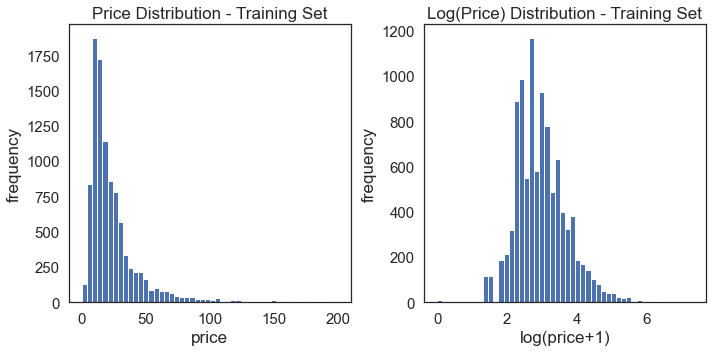

In [8]:
# 原始数据分布，显然不符合正态分布
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
train['price'].plot.hist(bins=50, edgecolor='white', range=[0, 200])
plt.xlabel('price', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Price Distribution - Training Set', fontsize=17)


plt.subplot(1, 2, 2)

# 使用log变换后，数据更接近正态分布
np.log(train['price']+1).plot.hist(bins=50, edgecolor='white')

plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Log(Price) Distribution - Training Set', fontsize=17)
plt.tight_layout()

In [9]:
# 查看包邮的比例，shipping这一列为1的共占0.44，
# 即包邮的商家占44%
train.shipping.value_counts(normalize=True)

0    0.5461
1    0.4539
Name: shipping, dtype: float64

## 看一下运费不同情况的价格变化

In [10]:
prc_shipBySeller = train.loc[train.shipping==1, 'price']
prc_shipByBuyer = train.loc[train.shipping==0, 'price']

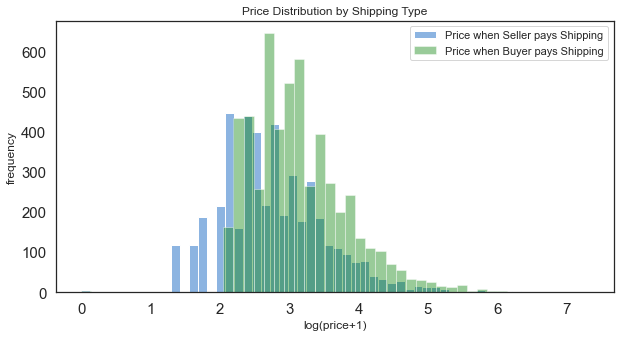

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(np.log(prc_shipBySeller+1), color='#8CB4E1', alpha=1.0, bins=50,
       label='Price when Seller pays Shipping')

ax.hist(np.log(prc_shipByBuyer+1), color='#007D00', alpha=0.4, bins=50,
       label='Price when Buyer pays Shipping')

ax.set(title='Histogram Comparison', ylabel='% of Dataset in Bin')

plt.legend()
plt.xlabel('log(price+1)')
plt.ylabel('frequency')
plt.title('Price Distribution by Shipping Type')
plt.tick_params(labelsize=15)

从结果上面看，包邮商品的价格整体上要高于不包邮商品的价格...

## 商品类别

In [12]:
print("There are %d unique values in the category column." % train['category_name'].nunique())
# 类别这一列未处理之前，共有626种不同的类别

There are 626 unique values in the category column.


In [13]:
# TOP 5 RAW CATEGORIES
train['category_name'].value_counts()[:5]

Women/Athletic Apparel/Pants, Tights, Leggings    396
Women/Tops & Blouses/T-Shirts                     294
Beauty/Makeup/Face                                271
Beauty/Makeup/Lips                                227
Beauty/Makeup/Eyes                                185
Name: category_name, dtype: int64

In [14]:
# missing categories
print("There are %d items that do not have a label." % train['category_name'].isnull().sum())
# 有47件商品的类别名缺失

There are 47 items that do not have a label.


## 类别细分一下

注意看类别的名称其实还可以再细分，例如Men/Tops/T-shirts，可以划分成Men，Tops，T-shirts分别对应general_cat，subcat_1，subcat_2

In [15]:
def split_cat(text):
    try: return text.split("/")
    # 如果类别为空值，返回下面这个列表
    except: return ["No Label", "No Label", "No Label"]
    

# 得到每个上面的类别划分结果，但还需要继续处理
category = train['category_name'].apply(lambda x: split_cat(x)).values

general_cat = []
subcat_1 = []
subcat_2 = []

for i in range(len(category)):
    general_cat.append(category[i][0])
    subcat_1.append(category[i][1])
    subcat_2.append(category[i][2])

# 现在给数据添加新的列
train['general_cat'] = general_cat
train['subcat_1'] = subcat_1
train['subcat_2'] = subcat_2

In [16]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [17]:
# 测试集上做同样的处理
category = test['category_name'].apply(lambda x: split_cat(x)).values

general_cat = []
subcat_1 = []
subcat_2 = []

for i in range(len(category)):
    general_cat.append(category[i][0])
    subcat_1.append(category[i][1])
    subcat_2.append(category[i][2])

# 现在给数据添加新的列
test['general_cat'] = general_cat
test['subcat_1'] = subcat_1
test['subcat_2'] = subcat_2

In [18]:
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7,Women,Jewelry,Rings
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",Other,Office supplies,Shipping Supplies
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,Vintage & Collectibles,Bags and Purses,Handbag
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...,Women,Sweaters,Cardigan
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...,Other,Books,Religion & Spirituality


In [19]:
# 主要类别共有10个(不包括No Label)
print("There are %d unique general categories." % train['general_cat'].nunique())
train['general_cat'].unique()

There are 11 unique general categories.


array(['Men', 'Electronics', 'Women', 'Home', 'Sports & Outdoors',
       'Vintage & Collectibles', 'Beauty', 'Other', 'Kids', 'No Label',
       'Handmade'], dtype=object)

In [20]:
print("There are %d unique first sub-categories." % train['subcat_1'].nunique())

There are 106 unique first sub-categories.


In [21]:
print("There are %d unique second sub-categories." % train['subcat_2'].nunique())

There are 478 unique second sub-categories.


## 各大主类别分布情况：

In [22]:
x = train['general_cat'].value_counts().index
x

Index(['Women', 'Beauty', 'Kids', 'Electronics', 'Men', 'Home', 'Other',
       'Vintage & Collectibles', 'Handmade', 'Sports & Outdoors', 'No Label'],
      dtype='object')

In [23]:
# 每个主类别占的数量
y = train['general_cat'].value_counts().values
y

array([4381, 1508, 1159,  816,  642,  433,  366,  311,  174,  163,   47],
      dtype=int64)

In [24]:
# 每个主类别所占的比例
pct = train['general_cat'].value_counts(normalize=True).values

# 注意要转换成字符串类型，同时舍入到两位小数
pct = np.around(pct, 2).astype(str)
pct

array(['0.44', '0.15', '0.12', '0.08', '0.06', '0.04', '0.04', '0.03',
       '0.02', '0.02', '0.0'], dtype='<U32')

## 下面使用plotly进行交互式绘图

In [25]:
import plotly.graph_objs as go
import plotly.offline as of

# 激活离线模式
of.init_notebook_mode(connected=True)

# 设置布局
layout = dict(title='Number of Items by Main Category',
              yaxis=dict(title='Count'), xaxis=dict(title='Category'),
                template="plotly_white")
layout

{'title': 'Number of Items by Main Category',
 'yaxis': {'title': 'Count'},
 'xaxis': {'title': 'Category'},
 'template': 'plotly_white'}

In [26]:
trace_1 = go.Bar(x=x, y=y, text=pct)

fig = go.Figure(data=[trace_1], layout=layout)
fig

## subcat_1类别分布情况

In [27]:
# 由于subcat_1类别数量较多，这里只取前10个
# value_counts()方法会自动根据频率降序排序
# 因此只需要使用index属性即可
x = train['subcat_1'].value_counts().index[:10]
x

Index(['Makeup', 'Athletic Apparel', 'Shoes', 'Tops & Blouses', 'Jewelry',
       'Toys', 'Cell Phones & Accessories', 'Dresses', 'Women's Handbags',
       'Women's Accessories'],
      dtype='object')

In [28]:
y = train['subcat_1'].value_counts().values[:10]
y

array([918, 849, 688, 682, 428, 377, 366, 307, 306, 277], dtype=int64)

In [29]:
pct = np.around(train["subcat_1"].value_counts(normalize=True).values[:10], 2)
pct

array([0.09, 0.08, 0.07, 0.07, 0.04, 0.04, 0.04, 0.03, 0.03, 0.03])

In [30]:
# 还可以设置颜色映射
trace1 = go.Bar(x=x, y=y, text=pct,
                marker=dict(color = y, colorscale='Portland',showscale=True,
                reversescale = False))

layout = dict(title= 'Number of Items by Sub Category (Top 15)',
              yaxis = dict(title='Count'),
              xaxis = dict(title='SubCategory'),
                template="plotly_white")

fig = go.Figure(data=[trace1], layout=layout)
fig

## 使用盒形图查看每个类别所有商品的价格分布

In [31]:
general_cats = train['general_cat'].unique()

general_cats

array(['Men', 'Electronics', 'Women', 'Home', 'Sports & Outdoors',
       'Vintage & Collectibles', 'Beauty', 'Other', 'Kids', 'No Label',
       'Handmade'], dtype=object)

In [32]:
# 从所有数据中提取所有对应主类别商品的价格
x = [train.loc[train['general_cat']==cat, 'price'] for cat in general_cats]

# x是一个列表类型，每个元素的类型是series对象
x[0]

0       10.0
25      66.0
37       6.0
64      36.0
78       9.0
        ... 
9950    17.0
9952    24.0
9958     7.0
9974    30.0
9983    16.0
Name: price, Length: 642, dtype: float64

In [33]:
# 为了使数据分布集中，使用log变换
# 为每个类别创建一个盒形图对象
data = [go.Box(x=np.log(x[i]+1), name=general_cats[i]) for i in range(len(general_cats))]

layout = dict(title="Price Distribution by General Category",
                template="plotly_white")

fig = go.Figure(data=data, layout=layout)
# of.iplot(fig)
fig
# 盒形图可以观察数据的中位数

## 品牌名字

看完类别现在来看看每个商品的品牌

In [34]:
print("There are %d unique brand names in the training dataset." % train['brand_name'].nunique())

There are 761 unique brand names in the training dataset.


In [35]:
x = train['brand_name'].value_counts().index[:10]

# 商品数量前10的品牌的名字
x

Index(['Nike', 'PINK', 'Victoria's Secret', 'LuLaRoe', 'Apple', 'FOREVER 21',
       'Nintendo', 'Michael Kors', 'Sephora', 'Bath & Body Works'],
      dtype='object')

In [36]:
y = train['brand_name'].value_counts().values[:10]

# 每个品牌对应商品的数量
y

array([350, 348, 322, 201, 111, 108,  99,  87,  86,  85], dtype=int64)

In [37]:
trace1 = go.Bar(x=x, y=y, 
                marker=dict(color = y,colorscale='Portland',showscale=True,
                 reversescale = False))

layout = dict(title= 'Top 10 Brand by Number of Items',
               yaxis = dict(title='Count'),
              xaxis = dict(title='Brand Name'),
               template="plotly_white")

fig = go.Figure(data=[trace1], layout=layout)
# py.iplot(fig)
fig

## 商品描述

由于商品描述是非结构化数据，因此解析这个特定字段会更具挑战性

我们先删除所有标点符号，删除一些英语停用词（即冗余词，如“a”，“the”等）以及长度小于3的任何其他词：

In [38]:
import re
import string

# escape()方法可以自动处理标点符号中的转义字符，
# 使用escape()方法就不用手动处理转义字符了
re.escape(string.punctuation)

'!"\\#\\$%\\&\'\\(\\)\\*\\+,\\-\\./:;<=>\\?@\\[\\\\\\]\\^_`\\{\\|\\}\\~'

In [39]:
from nltk.corpus import stopwords

# 英文停用词列表
stopwords_english = stopwords.words("english")
print(stopwords_english)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [40]:
# 统计'item_description'中包含的词数，统计之前要去除停用词
def wordCount(text):
    try:
        # convert to lower case and strip regex
        text = text.lower()
        regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        
        # 将文本串中所有能匹配的字符替换成空格
        txt = regex.sub(" ", text)
        cnt = 0
        
        # 去除停用词和长度小于4的词
        for w in txt.split(" "):
            if w.strip() not in stopwords_english and len(w) > 3:
                cnt = cnt + 1
                
        # 返回去除停用词后，剩余的单词数
        return cnt
    except: 
        return 0

In [41]:
# add a column of word counts to both the training and test set
# 数据量较大，下面两行代码的执行时间可能稍长
train['desc_len'] = train['item_description'].apply(lambda x: wordCount(x))
test['desc_len'] = test['item_description'].apply(lambda x: wordCount(x))

In [42]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2,desc_len
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts,1
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,14
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,10
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,14
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,3


In [43]:
# 根据描述的长度分组，描述长度相同的商品分为一组，
# 然后计算同一组内商品的平均价格，返回的是Series对象
desc_price = train.groupby('desc_len')['price'].mean()
desc_price

desc_len
0      24.500000
1      24.848758
2      23.636364
3      23.498141
4      22.610727
         ...    
113    25.000000
130    12.000000
131    19.000000
132    18.000000
137    24.000000
Name: price, Length: 115, dtype: float64

In [44]:
trace1 = go.Scatter(
    x = desc_price.index,
    y = np.log(desc_price+1),
    mode = 'lines+markers',
    name = 'lines+markers'
)

layout = dict(title= 'Average Log(Price) by Description Length',
              yaxis = dict(title='Average Log(Price)'),
              xaxis = dict(title='Description Length'),
               template = "plotly_white")

fig = go.Figure(data=[trace1], layout=layout)
fig
# 注意纵轴不是实际价格，而是取对数后的值

In [45]:
# 统计item_description这一列空值的个数
train.item_description.isnull().sum()

0

In [46]:
# remove missing values in item description
# notnull()的用法与isnull()相反，notnull()是判断哪一行不是空值
# 下面这行代码就把所有空值的行去除掉了，当然也可以用dropna()方法
train = train[pd.notnull(train['item_description'])]

## 文本数据处理

- 分词
- 去停用词
- 过滤筛选

In [47]:
from nltk.tokenize import word_tokenize

# 编译正则表达式，过滤标点符号和数字
pattern_1 = re.compile("[" + re.escape(string.punctuation) + "]|[0-9]+")

In [48]:
# 分词方法，整合了nltk的分词
def tokenize(text):
    
    ls = []
    text = text.lower()
    
    for w in word_tokenize(text):
        if w not in stopwords_english and not pattern_1.match(w) and len(w) > 3:
            ls.append(w)
    return ls

In [49]:
train['tokens'] = train['item_description'].apply(tokenize)
test['tokens'] = test['item_description'].apply(tokenize)

train["tokens"][:5]

0                                        [description]
1    [keyboard, great, condition, works, like, came...
2    [adorable, hint, lace, hole, back, pale, pink,...
3    [tags, leather, horses, retail, stand, foot, h...
4                [complete, certificate, authenticity]
Name: tokens, dtype: object

In [50]:
# 打印一下分词结果
for description, tokens in zip(train['item_description'].head(),
                              train['tokens'].head()):
    print('description:', description)
    print('tokens:', tokens)
    print()

description: No description yet
tokens: ['description']

description: This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
tokens: ['keyboard', 'great', 'condition', 'works', 'like', 'came', 'ports', 'tested', 'work', 'perfectly', 'lights', 'customizable', 'razer', 'synapse']

description: Adorable top with a hint of lace and a key hole in the back! The pale pink is a 1X, and I also have a 3X available in white!
tokens: ['adorable', 'hint', 'lace', 'hole', 'back', 'pale', 'pink', 'also', 'available', 'white']

description: New with tags. Leather horses. Retail for [rm] each. Stand about a foot high. They are being sold as a pair. Any questions please ask. Free shipping. Just got out of storage
tokens: ['tags', 'leather', 'horses', 'retail', 'stand', 'foot', 'high', 'sold', 'pair', 'questions', 'please', 'free', 'shipping', 'storage']

description: Comp

In [51]:
# 重置行索引
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [52]:
from collections import Counter

# create a dictionary of words for each category
# tokenize = nltk.data.load('tokenizers/punkt/english.pickle')  

cat_desc = dict()

# 把每个类别所有商品的描述先拼接成一个长长的字符串，
# 然后对这个字符串分词，再对分词结果进行过滤
for cat in general_cats: 
    ls = []
    
    for tokens in train.loc[train["general_cat"]==cat, "tokens"].values:
        ls += tokens
        
    cat_desc[cat] = ls
    
# 现在cat_desc中保存了每个类别对应的商品描述的所有词
cat_desc.keys()

dict_keys(['Men', 'Electronics', 'Women', 'Home', 'Sports & Outdoors', 'Vintage & Collectibles', 'Beauty', 'Other', 'Kids', 'No Label', 'Handmade'])

In [53]:
# 现在使用Counter类统计每个类别都有哪些词
allWordsCount = {cat:Counter(words) for cat, words in cat_desc.items()}

# 查看Women类别下出现频率最高的前20个词
Women_top20 = allWordsCount["Women"].most_common(20)
Women_top20

[('size', 1834),
 ('worn', 921),
 ('condition', 886),
 ('brand', 680),
 ('free', 659),
 ('black', 572),
 ('small', 499),
 ('shipping', 496),
 ('pink', 469),
 ('never', 458),
 ('great', 420),
 ('tags', 412),
 ('like', 412),
 ('price', 374),
 ('medium', 366),
 ('color', 344),
 ('cute', 334),
 ('used', 333),
 ('bundle', 326),
 ('large', 309)]

In [54]:
x = [w[0] for w in Women_top20]
y = [w[1] for w in Women_top20]

print(x, y)

['size', 'worn', 'condition', 'brand', 'free', 'black', 'small', 'shipping', 'pink', 'never', 'great', 'tags', 'like', 'price', 'medium', 'color', 'cute', 'used', 'bundle', 'large'] [1834, 921, 886, 680, 659, 572, 499, 496, 469, 458, 420, 412, 412, 374, 366, 344, 334, 333, 326, 309]


In [55]:
# 以Women这个类别为例，展示出该类别下商品描述中出现最多的词
trace1 = go.Bar(x=x, y=y)

layout = dict(title= 'Word Frequency',
              yaxis = dict(title='Count'),
              xaxis = dict(title='Word'),
              template = "plotly_white")

fig = go.Figure(data=[trace1], layout=layout)
fig

## 词云展示

In [56]:
# find the most common words for the top 4 categories
# 需要转换成dict类型
women100 = dict(Counter(cat_desc['Women']).most_common(100))
beauty100 = dict(Counter(cat_desc['Beauty']).most_common(100))
kids100 = dict(Counter(cat_desc['Kids']).most_common(100))
electronics100 = dict(Counter(cat_desc['Electronics']).most_common(100))

In [57]:
from wordcloud import WordCloud

def generate_wordcloud(tup):
    # 先创建出词云对象
    wordcloud = WordCloud(background_color="white", max_font_size=50)
    fig = wordcloud.fit_words(tup)
    
    return fig

Text(0.5, 1.0, 'Electronic Top 100')

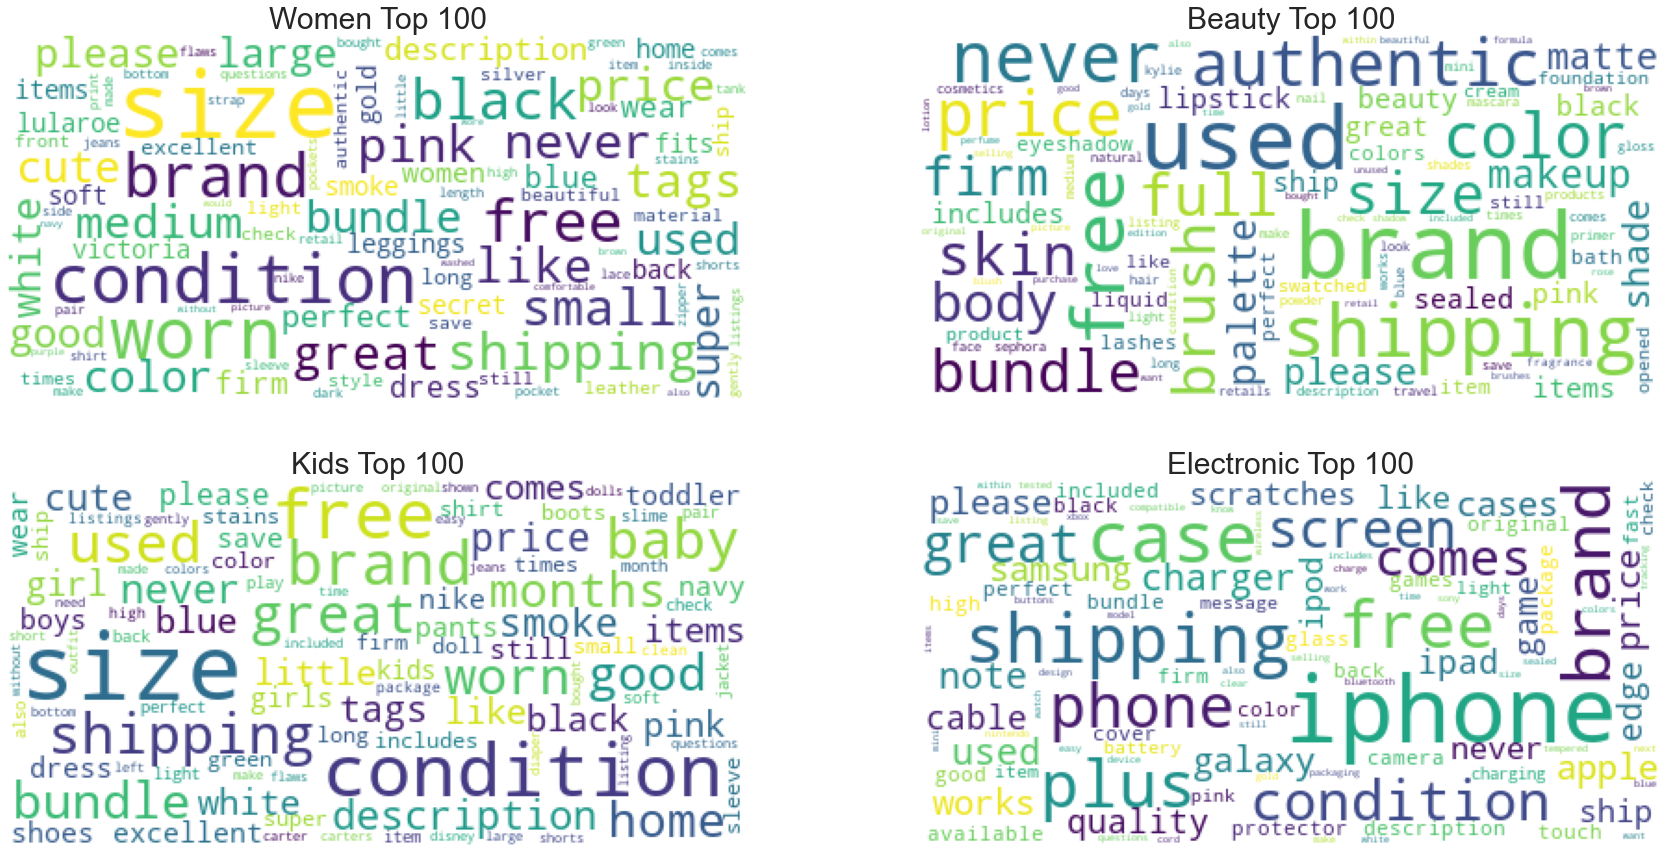

In [58]:
fig, axes = plt.subplots(2, 2, figsize=(30, 15))

ax = axes[0, 0]
ax.imshow(generate_wordcloud(women100))
ax.axis('off')
ax.set_title("Women Top 100", fontsize=30)

ax = axes[0, 1]
ax.imshow(generate_wordcloud(beauty100))
ax.axis('off')
ax.set_title("Beauty Top 100", fontsize=30)

ax = axes[1, 0]
ax.imshow(generate_wordcloud(kids100))
ax.axis('off')
ax.set_title("Kids Top 100", fontsize=30)

ax = axes[1, 1]
ax.imshow(generate_wordcloud(electronics100))
ax.axis('off')
ax.set_title("Electronic Top 100", fontsize=30)

## 制作tf-idf特征

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer

# min_df指定最低的文档频率，低于最低文档频率的词不会出现在词典中
# tokenizer可以指定自己定义的分词方法
vectorizer = TfidfVectorizer(min_df=10, max_features=2500,
                             tokenizer=tokenize, ngram_range=(1, 2))

In [60]:
# 将训练集和测试集的所有商品描述整合到一个列表中，构建出词典
all_desc = np.append(train['item_description'].values, test['item_description'].values)
vz = vectorizer.fit_transform(all_desc.tolist())

In [61]:
# 返回的是scipy库下封装的稀疏矩阵类，
# 可以调用toarray()方法转换成numpy数组
type(vz)

scipy.sparse.csr.csr_matrix

In [62]:
# 转换成numpy
vz = vz.toarray()

In [63]:
# get_feature_names()方法可以查看字典中的所有特征
vectorizer.get_feature_names()[:10]

['abercrombie',
 'abercrombie fitch',
 'able',
 'absolutely',
 'accent',
 'accents',
 'accept',
 'accepted',
 'access',
 'accessories']

In [64]:
# 现在所有文档都表示为一个向量
vz.shape

(11000, 2500)

In [65]:
# create a dictionary mapping the tokens to their tfidf values
tfidf = {"idf":vectorizer.idf_}
tfidf = pd.DataFrame(data=tfidf, index=vectorizer.get_feature_names_out())
tfidf

,idf
abercrombie,7.086866
abercrombie fitch,7.820835
able,6.973537
absolutely,6.521552
accent,7.533153
...,...
zippered,7.533153
zippers,7.415370
zips,7.597691
zoom,7.261219


以下是idf得分最低的10个词，这并不令人惊讶，因为这是我们无法区分一种描述与另一种描述的非常通用的词

In [66]:
tfidf.sort_values(by=['idf'], inplace=True)
tfidf.head(10)

,idf
size,2.378056
brand,2.776872
condition,2.852759
free,2.984553
shipping,3.093447
worn,3.145672
used,3.183682
never,3.289132
great,3.383098
price,3.472710


以下是idf分数最高的10个标记，其中包含很多具体的词，通过查看它们，我们可以猜出它们所属的分类：

In [67]:
tfidf.sort_values(by=['idf'], ascending=False, inplace=True)
tfidf.head(10)

,idf
plates,7.907846
planner,7.907846
slides,7.907846
surgical,7.907846
body jewelry,7.907846
infant,7.907846
bnip,7.907846
slippers,7.907846
santa,7.907846
lauder,7.907846


## 空间可视化

由于tfidf矩阵维度太高，需要使用奇异值分解(SVD)技术来降低它们的维数，比如先降低到30维， 进一步为了使我们的词汇可视化，我们接下来可以使用t-SNE算法将维度从30减小到2维，t-SNE更适合将维度减少到2(这么做是因为tsne算法非常耗时，因此先使用svd算法先降到30维)

In [68]:
trn = train.copy()
tst = test.copy()

# 添加一列
trn['is_train'] = 1
tst['is_train'] = 0

In [69]:
sample_sz = 5000

# 将训练集和测试集拼接在一起
combined_df = pd.concat([trn, tst])

# 采样5000条数据
combined_sample = combined_df.sample(n=sample_sz)

# 把item_description这一列转换成tfidf值
vz_sample = vectorizer.fit_transform(combined_sample['item_description'])

vz_sample.shape

(5000, 1391)

In [70]:
from sklearn.decomposition import TruncatedSVD

# 奇异值分解，降到30维
svd = TruncatedSVD(n_components=30)

svd_tfidf = svd.fit_transform(vz_sample)

svd_tfidf.shape

(5000, 30)

In [71]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2)

In [72]:
tsne_tfidf = tsne_model.fit_transform(svd_tfidf)

tsne_tfidf.shape

(5000, 2)

In [73]:
# 将数据降到2维后，查看散点图分布
trace1 = go.Scatter(x=tsne_tfidf[:, 0], y=tsne_tfidf[:, 1], mode="markers",
                   marker=dict(opacity=0.5))

layout = dict(yaxis = dict(title="Y"), xaxis = dict(title="X"), template = "plotly_white")

In [74]:
fig = go.Figure(data=[trace1], layout=layout)

fig

## K-Means聚类

In [75]:
from sklearn.cluster import MiniBatchKMeans

# need to be selected wisely，假设共有10个簇
kmeans_model = MiniBatchKMeans(n_clusters=10)

vz.shape

(11000, 2500)

In [76]:
kmeans = kmeans_model.fit(vz)

kmeans_clusters = kmeans.predict(vz)

# 每个样本到10个簇的距离
kmeans_distances = kmeans.transform(vz)

kmeans_distances.shape

(11000, 10)

In [77]:
# repeat the same steps for the sample
kmeans = kmeans_model.fit(vz_sample)

kmeans_clusters = kmeans.predict(vz_sample)

# 预测结果
kmeans_clusters

array([2, 2, 8, ..., 2, 8, 2])

In [78]:
kmeans_distances = kmeans.transform(vz_sample)

# reduce dimension to 2 using tsne
tsne_kmeans = tsne_model.fit_transform(kmeans_distances)

tsne_kmeans.shape

(5000, 2)

In [79]:
# 下面根据预测的类别进行可视化
trace1 = go.Scatter(x=tsne_kmeans[:, 0], y=tsne_kmeans[:, 1], mode="markers",
                   marker=dict(opacity=0.5, color=kmeans_clusters,
                            colorscale='Turbo', showscale=True))

layout = dict(yaxis=dict(title="Y"), xaxis=dict(title="X"), template="plotly_white")

fig = go.Figure(data=[trace1], layout=layout)

fig

## LDA模型

In [80]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# 词频向量化器
cvectorizer = CountVectorizer(min_df=4, max_features=2000, 
                              tokenizer=tokenize, ngram_range=(1,2))

In [81]:
cvz = cvectorizer.fit_transform(combined_sample['item_description'])

In [82]:
# n_components是主题数
lda_model = LatentDirichletAllocation(n_components=10, max_iter=20)

In [83]:
X_topics = lda_model.fit_transform(cvz)

In [84]:
# transform()方法返回的是每个文档属于每个主题的概率
X_topics

array([[0.00131623, 0.00131599, 0.00131652, ..., 0.00131592, 0.16733875,
        0.19579164],
       [0.77498338, 0.02500003, 0.02500783, ..., 0.02500012, 0.025     ,
        0.02500588],
       [0.00500152, 0.24146554, 0.0050019 , ..., 0.22301151, 0.19232116,
        0.0050027 ],
       ...,
       [0.00454564, 0.0045457 , 0.0045455 , ..., 0.00454549, 0.004546  ,
        0.57565843],
       [0.00217409, 0.00217416, 0.79578108, ..., 0.00217489, 0.00217447,
        0.00217411],
       [0.00312543, 0.00312541, 0.00312517, ..., 0.00312517, 0.00312568,
        0.00312554]])

In [85]:
X_topics.shape

(5000, 10)

In [86]:
# get the topic words
topic_word = lda_model.components_

# components_属性返回每个主题下每个词的得分，
# 这个得分反应该词属于这个主题的概率大小
topic_word

array([[ 0.1       ,  6.81540074,  0.18831818, ...,  0.10000116,
         0.10000767, 10.09997169],
       [ 0.10000503,  0.10000262,  1.54380549, ...,  0.10008128,
         0.10002099,  0.1000001 ],
       [ 0.10000545,  0.1       ,  3.24552011, ...,  0.10003319,
         0.10000458,  0.10001294],
       ...,
       [ 6.09979773,  0.1       ,  0.10005045, ...,  0.1000028 ,
         0.10000217,  0.10000579],
       [ 0.10004108,  0.1000671 ,  0.10001109, ...,  0.10002446,
         8.09993962,  0.10000041],
       [ 0.10007536,  0.1       , 15.51499084, ...,  0.1       ,
         0.1       ,  0.1       ]])

In [87]:
# 拿到特征名，也就是每个词
vocab = cvectorizer.get_feature_names()

In [88]:
# 转换成array数组
vocab = np.array(vocab)

In [89]:
# np.argsort(topic_word)是根据得分进行索引排序
# 由于是升序排序，因此应该取最后面的10个词
# 但是可以先对结果进行翻转，即word_index[: : -1]
# 这样就可以得到从大到小的结果了
word_index = np.argsort(topic_word, axis=1)

word_index = word_index[:, ::-1]

topic_words = vocab[word_index[0][:10]]
topic_words

array(['please', 'items', 'item', 'bundle', 'make', 'shipping', 'brand',
       'sealed', 'still', 'great'], dtype='<U19')

In [90]:
for i in range(0, len(word_index)):
    
    topic_words = vocab[word_index[i][:10]]
    print('Topic {}: {}'.format(i, ' | '.join(topic_words)))

Topic 0: please | items | item | bundle | make | shipping | brand | sealed | still | great
Topic 1: brand | never | used | never used | tags | authentic | without | size | gold | leather
Topic 2: used | full | color | skin | brand | body | matte | shade | lipstick | authentic
Topic 3: size | description | medium | large | small | super | black | size medium | like | leggings
Topic 4: shipping | free | free shipping | pink | please | bundle | ship | price | secret | victoria
Topic 5: worn | never | price | never worn | firm | size | price firm | brand | tags | white
Topic 6: free | home | smoke | smoke free | free home | brush | comes | glass | shipping | questions
Topic 7: iphone | case | plus | quality | phone | high | gold | brand | screen | high quality
Topic 8: condition | size | great | good | great condition | good condition | worn | wear | used | small
Topic 9: condition | bundle | excellent | size | save | excellent condition | bundle save | perfect | shipping | worn


In [91]:
# reduce dimension to 2 using tsne
tsne_lda = tsne_model.fit_transform(X_topics)

In [92]:
tsne_lda.shape

(5000, 2)

In [93]:
# 取一个概率最大的主题作为一篇文档的主题
# 也相当于进行了分类
topic = np.argmax(X_topics, axis=1)
topic

array([4, 0, 1, ..., 9, 2, 3], dtype=int64)

In [94]:
# 根据每篇文档属于的主题进行聚类
trace2 = go.Scatter(x=tsne_lda[:, 0], y=tsne_lda[:, 1], mode="markers",
                   marker=dict(color=topic, colorscale='Turbo', showscale=True))

layout = dict(yaxis=dict(title="Y"), xaxis=dict(title="X"), template="plotly_white")

fig = go.Figure(data=[trace2], layout=layout)

fig
# 从分布上看LDA模型还是有一定分类效果的